##### Master Degree in Computer Science and Data Science for Economics

# Classification problems

### Alfio Ferrara

Classification is the problem of assigning a label to an entity, such as a text, based on a set of features. It can be modeled as a function that provides a probability distribution over the target labels given the features, such as:

$$
f : X  \rightarrow \Delta_Y
$$

where $X$ denoted the features and $Y$ the labels. Thus, given a single input $x \in X$, $f(x)$ returns a vector $\mathbf{p}(x) \in \Delta_Y$ such that:

$$
\mathbf{p}(x) = \begin{bmatrix}
p_1(x) \\
p_2(x) \\
\dots \\
p_{\mid Y \mid}(x)
\end{bmatrix}
$$

provided that 

$$
\sum\limits_{i=1}^{\mid Y \mid} p_i(x) = 1,\ ;\ p_i(x) \geq 0 \forall i
$$

### Properties of classification
A classification problem can be:
- A **binary partition**: each input data point can be assigned to one label only among two possible labels
- A **soft binary classification**: each input data point can be assigned to one or two labels among two possible labels
- A **partition**, called **multi-class classification**: each input data point can be assigned to one class only among many
- A **a soft classification**, called **multi-label classification**: each input data point can be assigne to multiple labels among many

## Classify recipes by ingredients

In [1]:
import pymongo
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
db = pymongo.MongoClient()['cousine']
recipes = db['foodcom']
label_field = 'category'
data = []
labels = ['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'polish']

q = {'search_terms': {'$in': labels}}
for recipe in recipes.find(q):
    data.append({
        'ingredients': recipe['ingredients'],
        label_field: [x for x in recipe['search_terms'] if x in labels][0]
    })

In [4]:
print(len(data))
data[0]

65212


{'ingredients': ['zucchini',
  'yellow squash',
  'diced tomatoes',
  'onion',
  'garlic',
  'green bell pepper',
  'italian seasoning',
  'water',
  'salt and pepper'],
 'category': 'italian'}

In [5]:
labels

['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'polish']

### Encoding features and labels

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
tokenizer = lambda x: x.split("|")
ingredients_encoder = CountVectorizer(tokenizer=tokenizer, token_pattern=None, binary=True, min_df=20)
labels_encoder = CountVectorizer(tokenizer=tokenizer, token_pattern=None, binary=True)

In [8]:
X = ingredients_encoder.fit_transform(["|".join(x['ingredients']) for x in data]).toarray()
y = labels_encoder.fit_transform([x[label_field] for x in data]).toarray()

In [9]:
print(f"Features: {X.shape}")
print(f"Labels: {y.shape}")

Features: (65212, 2345)
Labels: (65212, 7)


## Check for the dates properties and split in train and test datasets

In [10]:
from sklearn.model_selection import train_test_split

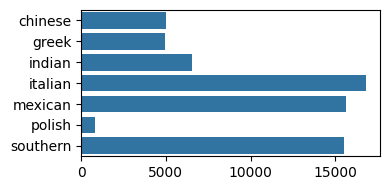

In [11]:
fig, ax = plt.subplots(figsize=(4, 2))
sns.barplot(x=y.sum(axis=0), y=labels_encoder.get_feature_names_out(), ax=ax)
plt.tight_layout()
plt.show()

In [12]:
labels = labels_encoder.get_feature_names_out()
y_true = [labels[int(np.where(a == 1)[0][0])] for a in y]
y_true[:5]

['italian', 'italian', 'italian', 'mexican', 'mexican']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, train_size=.7)

## Classic classifiers

In [14]:
from bornrule import BornClassifier

In [15]:
born = BornClassifier()
born.fit(X_train, y_train)

BornClassifier()

In [16]:
y_pred = born.predict(X_test)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/bornrule/born.py:174: RuntimeWarning: divide by zero encountered in matmul
  u = self._power(self._power(X, self.a) @ self._weights(), 1. / self.a)
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/bornrule/born.py:174: RuntimeWarning: overflow encountered in matmul
  u = self._power(self._power(X, self.a) @ self._weights(), 1. / self.a)
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/bornrule/born.py:174: RuntimeWarning: invalid value encountered in matmul
  u = self._power(self._power(X, self.a) @ self._weights(), 1. / self.a)


In [17]:
y_pred[:5]

array(['indian', 'southern', 'southern', 'mexican', 'greek'], dtype='<U8')

## Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation='vertical')
plt.show()

## Explainability

### Local explanation

In [18]:
test_recipe = ['potatoes', 'onions', 'salt', 'mushrooms', 'olive oil', 'soy sauce']
vector = ingredients_encoder.transform(["|".join(test_recipe)]).toarray()
print(born.predict(vector)[0])
print(pd.Series(born.predict_proba(vector)[0], index=labels))

chinese
chinese     0.570239
greek       0.090319
indian      0.064176
italian     0.071807
mexican     0.045160
polish      0.083145
southern    0.075154
dtype: float64


In [19]:
local_explain = pd.DataFrame(born.explain(vector), index=ingredients_encoder.get_feature_names_out(), columns=labels)
local_explain.head()

,chinese,greek,indian,italian,mexican,polish,southern
,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1%25 low-fat milk,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10-inch flour tortillas,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2%25 low-fat milk,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6-inch corn tortillas,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
local_explain['chinese'].sort_values(ascending=False).head(10)

soy sauce         0.068474
olive oil         0.004418
potatoes          0.002054
mushrooms         0.001807
onions            0.001144
salt              0.000810
                  0.000000
parsnips          0.000000
parsley           0.000000
parsley flakes    0.000000
Name: chinese, dtype: float64

### Global explanation

In [21]:
global_explain = pd.DataFrame(born.explain(X_test), index=ingredients_encoder.get_feature_names_out(), columns=labels)

In [22]:
global_explain.head()

,chinese,greek,indian,italian,mexican,polish,southern
,0.002305,0.003634,0.006902,0.003283,0.003913,0.004275,0.002438
1%25 low-fat milk,0.005198,0.000000,0.002521,0.007903,0.005986,0.000000,0.003413
10-inch flour tortillas,0.000000,0.000000,0.000000,0.000000,0.012283,0.000000,0.002246
2%25 low-fat milk,0.000763,0.001287,0.001732,0.001752,0.002463,0.002142,0.002802
6-inch corn tortillas,0.000000,0.000000,0.000000,0.001730,0.009882,0.000000,0.000000


In [25]:
global_explain.sort_values(by='polish', ascending=False).head(10)

,chinese,greek,indian,italian,mexican,polish,southern
sour cream,0.055141,0.149622,0.116124,0.136036,0.494613,0.559770,0.283952
butter,0.146253,0.282188,0.239047,0.299237,0.208195,0.464682,0.423960
olive oil,0.214618,0.783885,0.327467,0.689140,0.411598,0.338649,0.321825
parmesan cheese,0.076237,0.536922,0.096270,1.238708,0.236506,0.332173,0.426641
flour,0.126271,0.167532,0.114246,0.164451,0.135402,0.329388,0.225971
sauerkraut,0.012834,0.000000,0.000000,0.011855,0.010423,0.277828,0.025149
cheddar cheese,0.043987,0.072517,0.062082,0.135609,0.445188,0.258537,0.249341
polish sausage,0.000000,0.000000,0.000000,0.005780,0.000000,0.211886,0.022659
bacon,0.057902,0.044701,0.022704,0.091540,0.088515,0.194133,0.160870
cornstarch,0.679920,0.128594,0.142592,0.143692,0.134216,0.193228,0.218200
